<a href="https://colab.research.google.com/github/JyothyVariyampat/Benchmark-ML-and-DL-Models-for-Small-Molecule-Immunity-Target-Bioactivity-Prediction./blob/main/CW_AID_1578.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Environment setup
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Debug CUDA asserts
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu118.html
# !pip install torch-geometric

#!pip install torch_geometric
!pip install torch-geometric==2.5.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00


In [ ]:
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 85.3 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.24.4
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime


In [ ]:
import pandas as pd
import numpy as np


In [ ]:
# Ensure reproducibility
import random
random.seed(42)
np.random.seed(42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, SanitizeMol
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelReturnType

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data loading and preprocessing
# def compute_rdkit_features(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     try:
#         # Attempt to sanitize the molecule
#         SanitizeMol(mol)
#     except:
#         print(f"Failed to sanitize SMILES: {smiles}")
#         return None
#     return [
#         Descriptors.MolWt(mol),
#         Descriptors.MolLogP(mol),
#         Descriptors.TPSA(mol),
#         Descriptors.NumHDonors(mol),
#         Descriptors.NumHAcceptors(mol)
#     ]

from rdkit.Chem import Lipinski

def compute_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        SanitizeMol(mol)
    except:
        print(f"Failed to sanitize SMILES: {smiles}")
        return None

    # Compute updated concept descriptors
    return [
        Descriptors.TPSA(mol),                  # 1. Topological Polar Surface Area
        Descriptors.MolLogP(mol),               # 2. LogP
        Descriptors.NumHDonors(mol),            # 3. Hydrogen Bond Donors
        #Lipinski.NumAromaticRings(mol),         # 4. Number of Aromatic Rings
        Descriptors.NumRotatableBonds(mol),     # 4. NumRotatableBonds
        Descriptors.MolMR(mol)                  # 5. Molar Refractivity
    ]



# def mol_to_graph(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None
#     G = nx.Graph()
#     for atom in mol.GetAtoms():
#         G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
#     for bond in mol.GetBonds():
#         start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
#         G.add_edge(start, end)
#     data = from_networkx(G)
#     data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
#     return data

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), x=torch.tensor([atom.GetAtomicNum()], dtype=torch.float))
    edge_indices = []
    edge_attrs = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        G.add_edge(start, end)
        edge_indices.append((start, end))
        edge_indices.append((end, start))  # For undirected graph
        bond_type = bond.GetBondTypeAsDouble()  # Simplified edge feature
        edge_attrs.append([bond_type])
        edge_attrs.append([bond_type])
    data = from_networkx(G)
    data.x = torch.stack([feat["x"] for _, feat in G.nodes(data=True)])
    data.edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    data.edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    return data


def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    dataset, failed = [], 0
    for idx, row in df.iterrows():
        smiles = row['SMILES']
        label = 1 if row['PUBCHEM_ACTIVITY_OUTCOME'].lower() == 'active' else 0
        features = compute_rdkit_features(smiles)
        graph = mol_to_graph(smiles)
        if features is None or graph is None:
            failed += 1
            continue
        graph.y = torch.tensor(label, dtype=torch.long)
        graph.mol_features = torch.tensor(features, dtype=torch.float)
        dataset.append(graph)
    print(f"Processed {len(dataset)} molecules. Failed: {failed}")
    return dataset, df

In [ ]:
# CHANGE THIS PATH to your CSV file
csv_path = "/content/AID1578Sampled_4000_molecules_smiles (1).csv"
dataset, df_raw = load_dataset(csv_path)

Processed 4000 molecules. Failed: 0


In [ ]:
# Data splitting
train_idx, test_idx = train_test_split(
    range(len(dataset)), test_size=0.2,
    stratify=[data.y.item() for data in dataset], random_state=42)

train_set = [dataset[i] for i in train_idx]
test_set = [dataset[i] for i in test_idx]

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)


In [ ]:
# Model definition
from torch_geometric.nn import AttentiveFP

# Define Concept Whitening Layer
class ConceptWhiteningLayer(nn.Module):
    def __init__(self, input_dim, concept_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, concept_dim)
        self.R = nn.Parameter(torch.eye(concept_dim), requires_grad=True)

    def forward(self, x, concept_vectors):
        x_centered = x - x.mean(dim=0, keepdim=True)
        concept_space = self.proj(x_centered)
        aligned = concept_space @ self.R
        self.loss = F.mse_loss(aligned, concept_vectors) if concept_vectors is not None else torch.tensor(0.0, device=x.device)
        return aligned

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x

class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim, concept_dim, num_classes):
        super().__init__()
        self.encoder = GCNEncoder(in_channels, hidden_dim)
        self.pool = global_mean_pool
        self.cw_layer = ConceptWhiteningLayer(hidden_dim, concept_dim)
        self.fc = nn.Linear(concept_dim, num_classes)

    def forward(self, data):
        x = self.encoder(data.x, data.edge_index)
        x = self.pool(x, data.batch)
        mol_concepts = data.mol_features.view(x.size(0), -1)
        x = self.cw_layer(x, mol_concepts)
        return self.fc(x), self.cw_layer.loss

In [ ]:
# Training functions
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, align_loss = model(data)
        cls_loss = F.cross_entropy(out, data.y)
        loss = cls_loss + align_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    for data in loader:
        data = data.to(device)
        out, _ = model(data)
        prob = F.softmax(out, dim=1)[:, 1]
        pred = out.argmax(dim=1)
        y_true += data.y.cpu().tolist()
        y_pred += pred.cpu().tolist()
        y_prob += prob.cpu().tolist()
    return accuracy_score(y_true, y_pred), roc_auc_score(y_true, y_prob)


In [ ]:
# Model, optimizer initialization
in_channels = dataset[0].x.shape[1]
model = GCNClassifier(in_channels, 128, 5, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Training loop
for epoch in range(1, 31):
    loss = train(model, train_loader, optimizer)
    acc, roc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Accuracy: {acc:.4f} | ROC-AUC: {roc:.4f}")


Epoch 01 | Loss: 3245.7164 | Accuracy: 0.5000 | ROC-AUC: 0.4390
Epoch 02 | Loss: 3245.2132 | Accuracy: 0.5000 | ROC-AUC: 0.5607
Epoch 03 | Loss: 3244.6982 | Accuracy: 0.5000 | ROC-AUC: 0.5607
Epoch 04 | Loss: 3244.1744 | Accuracy: 0.5000 | ROC-AUC: 0.5607
Epoch 05 | Loss: 3243.6325 | Accuracy: 0.5000 | ROC-AUC: 0.5608
Epoch 06 | Loss: 3243.0737 | Accuracy: 0.4900 | ROC-AUC: 0.5608
Epoch 07 | Loss: 3242.4623 | Accuracy: 0.5325 | ROC-AUC: 0.5608
Epoch 08 | Loss: 3241.8349 | Accuracy: 0.5500 | ROC-AUC: 0.5608
Epoch 09 | Loss: 3241.1636 | Accuracy: 0.5575 | ROC-AUC: 0.5608
Epoch 10 | Loss: 3240.4581 | Accuracy: 0.5487 | ROC-AUC: 0.5608
Epoch 11 | Loss: 3239.6817 | Accuracy: 0.5513 | ROC-AUC: 0.5608
Epoch 12 | Loss: 3238.8957 | Accuracy: 0.5513 | ROC-AUC: 0.5608
Epoch 13 | Loss: 3238.0464 | Accuracy: 0.5550 | ROC-AUC: 0.5609
Epoch 14 | Loss: 3237.1318 | Accuracy: 0.5563 | ROC-AUC: 0.5609
Epoch 15 | Loss: 3236.2253 | Accuracy: 0.5563 | ROC-AUC: 0.5609
Epoch 16 | Loss: 3235.1531 | Accuracy: 0


 Running Explainability on Last 5 Molecules...

🔬 Molecule 796
SMILES: CC1=CC=C(C=C1)N=C2C(=CC3=C(O2)C=C(C=C3)O)C(=O)N
TPSA: 88.820
LogP: 2.778
NumHDonors: 2.000
NumRotatableBonds: 2.000
MolMR: 82.799
Node mask has constant values. Skipping visualization.


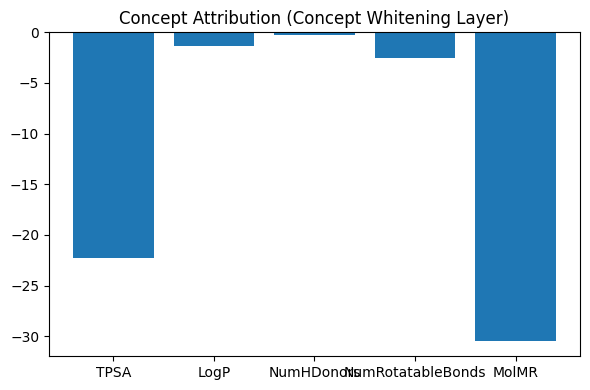


🔬 Molecule 797
SMILES: C1=CC=C(C=C1)C2=CSC(=N2)C(=C3SC=CS3)C#N
TPSA: 36.680
LogP: 4.953
NumHDonors: 0.000
NumRotatableBonds: 2.000
MolMR: 84.405
Node mask has constant values. Skipping visualization.


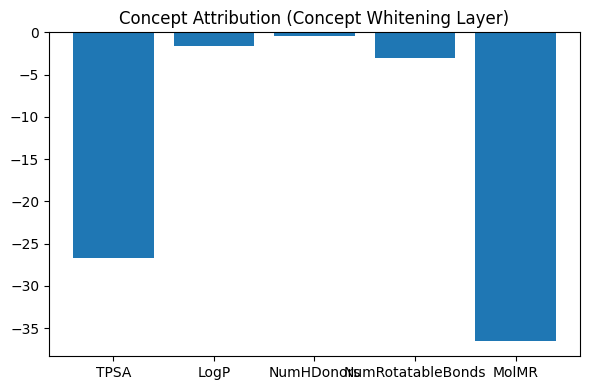


🔬 Molecule 798
SMILES: C1=CC=C(C=C1)C2=C(N=C(NC2=O)SCC3=C(C=CC=C3Cl)F)N
TPSA: 71.770
LogP: 4.104
NumHDonors: 2.000
NumRotatableBonds: 4.000
MolMR: 95.677
Node mask has constant values. Skipping visualization.


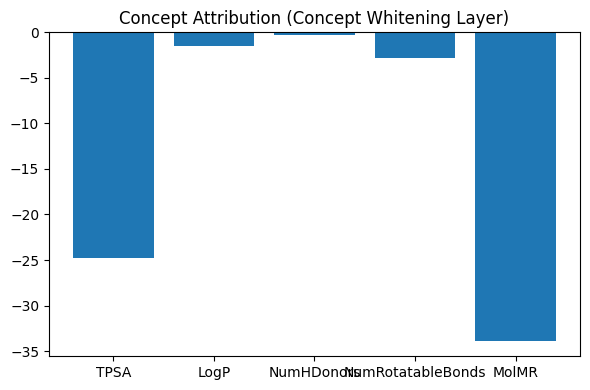


🔬 Molecule 799
SMILES: COC1=C(C(=C(C=C1)C2C(=C(OC3=NNC(=C23)C4=CC=CC=N4)N)C#N)OC)OC
TPSA: 128.300
LogP: 2.716
NumHDonors: 2.000
NumRotatableBonds: 5.000
MolMR: 107.214
Node mask has constant values. Skipping visualization.


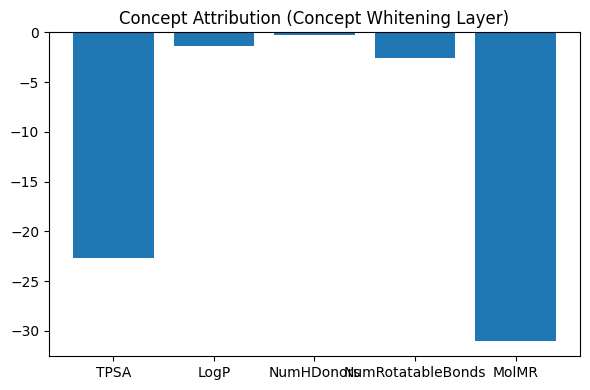


🔬 Molecule 800
SMILES: COC1=CC=C(C=C1)S(=O)(=O)NCC2=CC=C(C=C2)C(=O)O
TPSA: 92.700
LogP: 1.872
NumHDonors: 2.000
NumRotatableBonds: 6.000
MolMR: 80.421
Node mask has constant values. Skipping visualization.


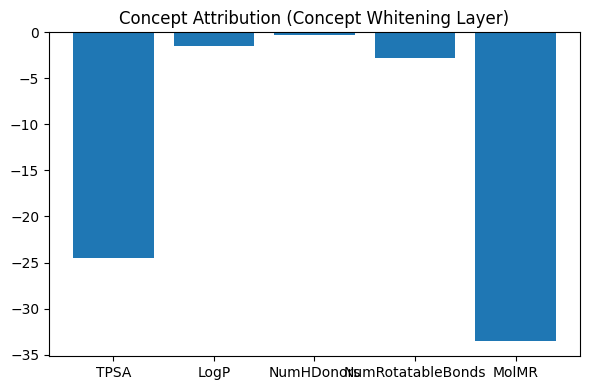

In [ ]:
# Explanation utilities
class WrappedModel(nn.Module):
    def __init__(self, base_model, mol_features):
        super().__init__()
        self.base_model = base_model
        self.mol_features = mol_features

    def forward(self, x, edge_index, batch, **kwargs):
        data = Data(x=x, edge_index=edge_index, batch=batch)
        data.mol_features = self.mol_features
        out, _ = self.base_model(data)
        return out

def visualize_rdkit_colored(smiles, node_mask):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES:", smiles)
        return

    try:
        node_mask = node_mask.cpu().detach().numpy()

        # Handle NaN or Inf values
        if np.isnan(node_mask).any() or np.isinf(node_mask).any():
            print("Node mask contains NaN or Inf values. Skipping visualization.")
            return

        # Avoid division by zero
        if np.allclose(node_mask.max(), node_mask.min()):
            print("Node mask has constant values. Skipping visualization.")
            return

        # Normalize node mask
        node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
        atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

        # Generate the image
        img = Draw.MolToImage(
            mol,
            size=(400, 300),
            highlightAtoms=list(atom_weights.keys()),
            highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
        )

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title("RDKit Atom Attribution Map")
        plt.show()

    except Exception as e:
        print("RDKit Visualization Error:", e)

def plot_concept_importance(model, data, device, concept_names=None):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = model.encoder(x, edge_index)
        x = model.pool(x, batch)
        concepts = model.cw_layer.proj(x) @ model.cw_layer.R
        concepts = concepts[0].cpu().numpy()

    if concept_names is None:
        concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]




    plt.figure(figsize=(6, 4))
    plt.bar(concept_names, concepts)
    plt.title("Concept Attribution (Concept Whitening Layer)")
    plt.tight_layout()
    plt.show()

# Explanation loop
# print("\nRunning Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f" Failed to explain molecule {i}: {e}")

# 🔍 Explanation loop for last 5 test molecules
print("\n Running Explainability on Last 5 Molecules...")
last_five_indices = list(range(len(test_set) - 5, len(test_set)))

concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]

for j, i in enumerate(last_five_indices):
    print(f"\n🔬 Molecule {len(test_set) - 5 + j + 1}")
    sample = test_set[i].to(device)

    # Skip small molecules
    if len(sample.x) < 3:
        print("Skipping molecule with too few atoms")
        continue

    try:
        # Print SMILES + Concept values
        smiles = df_raw.iloc[test_idx[i]]['SMILES']  # Correct indexing
        concept_values = sample.mol_features.cpu().numpy()

        print(f"SMILES: {smiles}")
        for name, value in zip(concept_names, concept_values):
            print(f"{name}: {value:.3f}")

        # Wrap the model
        wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)

        # GNNExplainer setup
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=ModelConfig(
                mode=ModelMode.binary_classification,
                task_level='graph',
                return_type=ModelReturnType.probs,
            )
        )

        # Generate explanation
        explanation = explainer(
            x=sample.x,
            edge_index=sample.edge_index,
            batch=sample.batch
        )

        node_mask = explanation.node_mask

        # 🔬 RDKit visualization
        visualize_rdkit_colored(smiles, node_mask)

        # 📊 Concept attribution bar plot
        plot_concept_importance(model, sample, device, concept_names)

    except Exception as e:
        print(f"Failed to explain molecule {i}: {e}")



 Running Explainability on Last 5 Molecules...

🔬 Molecule 796
SMILES: CC1=CC=C(C=C1)N=C2C(=CC3=C(O2)C=C(C=C3)O)C(=O)N
TPSA: 88.820
LogP: 2.778
NumHDonors: 2.000
NumAromaticRings: 2.000
MolMR: 82.799
Node mask has constant values. Skipping visualization.


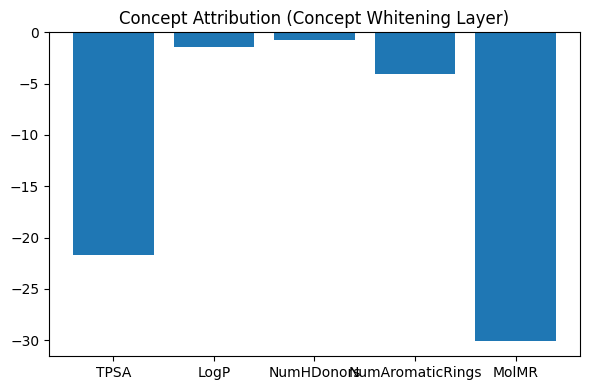


🔬 Molecule 797
SMILES: C1=CC=C(C=C1)C2=CSC(=N2)C(=C3SC=CS3)C#N
TPSA: 36.680
LogP: 4.953
NumHDonors: 0.000
NumAromaticRings: 2.000
MolMR: 84.405
Node mask has constant values. Skipping visualization.


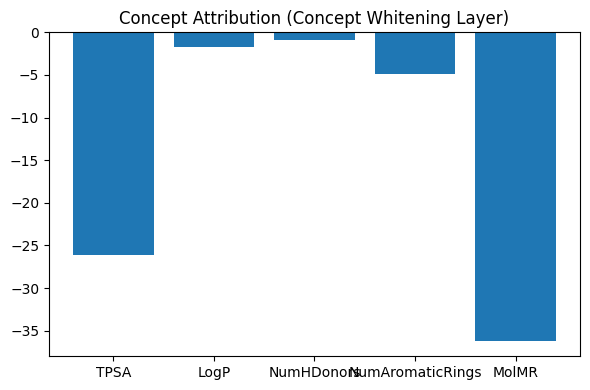


🔬 Molecule 798
SMILES: C1=CC=C(C=C1)C2=C(N=C(NC2=O)SCC3=C(C=CC=C3Cl)F)N
TPSA: 71.770
LogP: 4.104
NumHDonors: 2.000
NumAromaticRings: 4.000
MolMR: 95.677
Node mask has constant values. Skipping visualization.


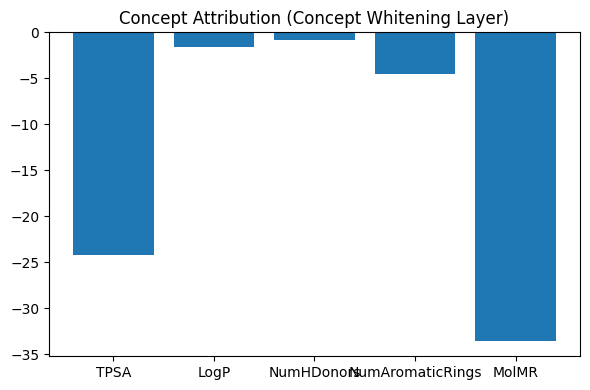


🔬 Molecule 799
SMILES: COC1=C(C(=C(C=C1)C2C(=C(OC3=NNC(=C23)C4=CC=CC=N4)N)C#N)OC)OC
TPSA: 128.300
LogP: 2.716
NumHDonors: 2.000
NumAromaticRings: 5.000
MolMR: 107.214
Node mask has constant values. Skipping visualization.


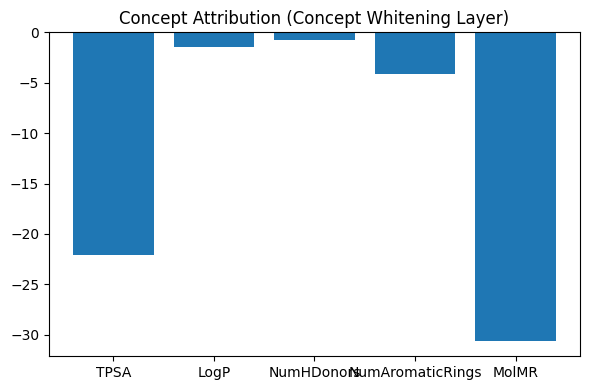


🔬 Molecule 800
SMILES: COC1=CC=C(C=C1)S(=O)(=O)NCC2=CC=C(C=C2)C(=O)O
TPSA: 92.700
LogP: 1.872
NumHDonors: 2.000
NumAromaticRings: 6.000
MolMR: 80.421
Node mask has constant values. Skipping visualization.


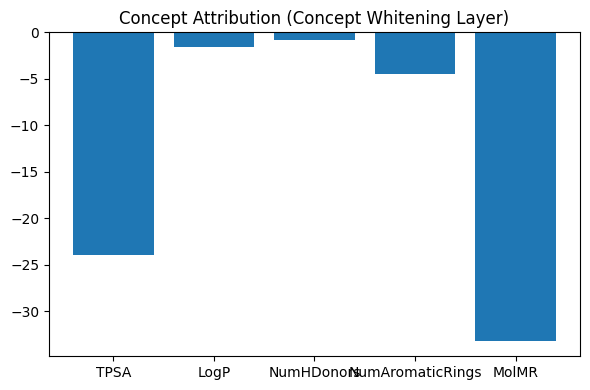

In [ ]:
# Explanation utilities
class WrappedModel(nn.Module):
    def __init__(self, base_model, mol_features):
        super().__init__()
        self.base_model = base_model
        self.mol_features = mol_features

    def forward(self, x, edge_index, batch, **kwargs):
        data = Data(x=x, edge_index=edge_index, batch=batch)
        data.mol_features = self.mol_features
        out, _ = self.base_model(data)
        return out

def visualize_rdkit_colored(smiles, node_mask):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES:", smiles)
        return

    try:
        node_mask = node_mask.cpu().detach().numpy()

        # Handle NaN or Inf values
        if np.isnan(node_mask).any() or np.isinf(node_mask).any():
            print("Node mask contains NaN or Inf values. Skipping visualization.")
            return

        # Avoid division by zero
        if np.allclose(node_mask.max(), node_mask.min()):
            print("Node mask has constant values. Skipping visualization.")
            return

        # Normalize node mask
        node_mask = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-8)
        atom_weights = {i: float(node_mask[i]) for i in range(len(node_mask))}

        # Generate the image
        img = Draw.MolToImage(
            mol,
            size=(400, 300),
            highlightAtoms=list(atom_weights.keys()),
            highlightAtomColors={i: (1.0, 0.5 * w, 0.5 * w) for i, w in atom_weights.items()},
        )

        plt.figure(figsize=(4, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.title("RDKit Atom Attribution Map")
        plt.show()

    except Exception as e:
        print("RDKit Visualization Error:", e)

def plot_concept_importance(model, data, device, concept_names=None):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = model.encoder(x, edge_index)
        x = model.pool(x, batch)
        concepts = model.cw_layer.proj(x) @ model.cw_layer.R
        concepts = concepts[0].cpu().numpy()

    if concept_names is None:
        concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]




    plt.figure(figsize=(6, 4))
    plt.bar(concept_names, concepts)
    plt.title("Concept Attribution (Concept Whitening Layer)")
    plt.tight_layout()
    plt.show()

# Explanation loop
# print("\nRunning Explainability on Last 5 Molecules...")
# last_five_indices = list(range(len(test_set) - 5, len(test_set)))

# for i in last_five_indices:
#     print(f"\n Molecule {i+1}")
#     sample = test_set[i].to(device)

#     # Skip small molecules
#     if len(sample.x) < 3:
#         print("Skipping molecule with too few atoms")
#         continue

#     try:
#         wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)  # Ensure model is on the same device
#         explainer = Explainer(
#             model=wrapped_model,
#             algorithm=GNNExplainer(epochs=200),
#             explanation_type='model',
#             node_mask_type='attributes',
#             edge_mask_type='object',
#             model_config=ModelConfig(
#                 mode=ModelMode.binary_classification,
#                 task_level='graph',
#                 return_type=ModelReturnType.probs,
#             )
#         )

#         explanation = explainer(
#             x=sample.x,
#             edge_index=sample.edge_index,
#             batch=sample.batch
#         )

#         node_mask = explanation.node_mask
#         smiles = df_raw.iloc[train_idx[i]]['SMILES']  # Correct SMILES extraction
#         visualize_rdkit_colored(smiles, node_mask)
#         plot_concept_importance(model, sample, device)

#     except Exception as e:
#         print(f" Failed to explain molecule {i}: {e}")

# 🔍 Explanation loop for last 5 test molecules
print("\n Running Explainability on Last 5 Molecules...")
last_five_indices = list(range(len(test_set) - 5, len(test_set)))

concept_names = ["TPSA", "LogP", "NumHDonors", "NumRotatableBonds", "MolMR"]

for j, i in enumerate(last_five_indices):
    print(f"\n🔬 Molecule {len(test_set) - 5 + j + 1}")
    sample = test_set[i].to(device)

    # Skip small molecules
    if len(sample.x) < 3:
        print("Skipping molecule with too few atoms")
        continue

    try:
        # Print SMILES + Concept values
        smiles = df_raw.iloc[test_idx[i]]['SMILES']  # Correct indexing
        concept_values = sample.mol_features.cpu().numpy()

        print(f"SMILES: {smiles}")
        for name, value in zip(concept_names, concept_values):
            print(f"{name}: {value:.3f}")

        # Wrap the model
        wrapped_model = WrappedModel(model, mol_features=sample.mol_features).to(device)

        # GNNExplainer setup
        explainer = Explainer(
            model=wrapped_model,
            algorithm=GNNExplainer(epochs=200),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=ModelConfig(
                mode=ModelMode.binary_classification,
                task_level='graph',
                return_type=ModelReturnType.probs,
            )
        )

        # Generate explanation
        explanation = explainer(
            x=sample.x,
            edge_index=sample.edge_index,
            batch=sample.batch
        )

        node_mask = explanation.node_mask

        # 🔬 RDKit visualization
        visualize_rdkit_colored(smiles, node_mask)

        # 📊 Concept attribution bar plot
        plot_concept_importance(model, sample, device, concept_names)

    except Exception as e:
        print(f"Failed to explain molecule {i}: {e}")
